# Hop Teaming Analysis - Community Detection

## Team: The Hindenburgs

![The Hindenburgs](../img/the_hindenburgs_propaganda.png)

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

## Community Detection

* Finally, look for "communities" of providers in the Nashville/Davidson County CBSA. Make use of the Louvain [community detection algorithm from Neo4j](https://neo4j.com/docs/graph-data-science/current/algorithms/louvain/)

For community detection, we extracted all of the NPIs belonging to the greater Nashville Area CBSA 34980. As discussed with the exploratory analysis, we decided to not additionally limit the data by selecting a zip_ratio.

In [3]:
query = """
SELECT
    from_npi,
    to_npi,
    transaction_count,
    patient_count
FROM hop_teaming AS hop
INNER JOIN nnpes AS n1
ON hop.from_npi = n1.npi
INNER JOIN zip_cbsa AS zc1
ON n1.address_postal_code = zc1.zip
INNER JOIN nnpes AS n2
ON hop.to_npi = n2.npi
INNER JOIN zip_cbsa AS zc2
ON n2.address_postal_code = zc2.zip
WHERE n1.address_state_name = 'TN'
    AND n2.address_state_name = 'TN'
    AND zc1.cbsa = 34980
    AND zc2.cbsa = 34980
"""

with sqlite3.connect('../data/hop_teaming_database.sqlite') as db: 
    hops_discovery = pd.read_sql(query, db)

hops_discovery.head()

,from_npi,to_npi,transaction_count,patient_count
0,1922001957,1578584199,148,129
1,1013910892,1790983104,139,133
2,1013910892,1811987050,53,53
3,1154324192,1578584199,206,202
4,1235132408,1093741464,133,112


In [ ]:
hops_discovery.to_csv('../data/hops_discovery.csv')

After saving that csv, the work was done in Neo4j as follows:
- create database hopsdiscovery
- use hopsdiscovery
- ```CREATE CONSTRAINT FOR (p:Provider) REQUIRE p.name IS UNIQUE;```
- open terminal from neo4j and then "open ." to open finder there and copy the .csv file into import

And then run this code:
```
LOAD CSV WITH HEADERS
FROM 'file:///hops_discovery.csv' AS line
WITH line

MERGE (from:Provider {name: line.from_npi})
MERGE (to:Provider {name: line.to_npi})

CREATE (from)-[:REFERRED {transaction_count: toInteger(line.transaction_count)}]->(to);
```

> Can also do something like this to show graph (note: it will only display 300 nodes since there's way more):
```
MATCH (:Provider)-[:REFERRED]->(p:Provider)
RETURN p
```

Next, run thnis script to prep the algorithm:
```
CALL gds.graph.project( 
    'hopsdiscovery',
    'Provider',
    {
        REFERRED: {
        orientation: 'UNDIRECTED', aggregation: 'SUM'
        }
    },
    {
        relationshipProperties: 'transaction_count'
    }
)
```

And then call algorithm on graph (and save as .csv):
```
CALL gds.louvain.stream('hopsdiscovery', { relationshipWeightProperty: 'transaction_count' }) YIELD nodeId, communityId
RETURN gds.util.asNode(nodeId).name AS name, communityId
ORDER BY name ASC
```

Results imported below, with both my data and Bua's.

In [4]:
louvain_community = pd.read_csv('../data/louvain_community.csv')
louvain_bua = pd.read_csv('../data/louvain.csv')

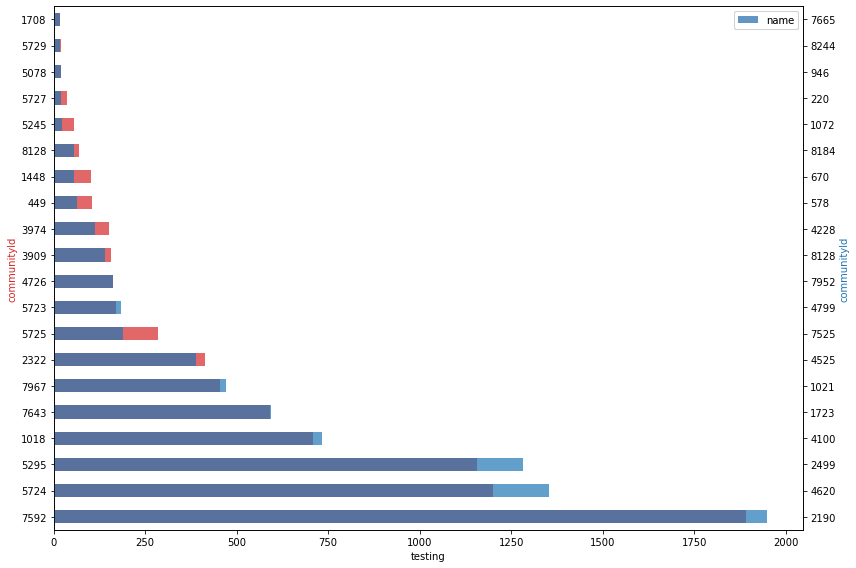

In [5]:
fig, ax1 = plt.subplots(figsize=(12, 8))

color = 'tab:red'
ax1.set_xlabel('testing')
ax1.set_ylabel('community ID', color=color)
louvain_community.groupby('communityId').count().nlargest(20, columns='name').plot(kind='barh', alpha=0.7, color=color, ax=ax1)
#ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('more testing', color=color)  # we already handled the x-label with ax1
louvain_bua.groupby('communityId').count().nlargest(20, columns='name').plot(kind='barh', alpha=0.7, color=color, ax=ax2)
#ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

The algorithm used on two different laptops yielded very similar results, which added confidence to the validity of it.

In [12]:
print('Number of communities:', louvain_community['communityId'].nunique())
print('Number of NPIs in communities:', louvain_community['name'].count())
print('Number of total referrals:', hops_discovery['transaction_count'].sum())

Number of communities: 241
Number of NPIs in communities: 8308
Number of total referrals: 45463255


The question then becomes: how many communities are 'impactful'?

In [77]:
communities_by_size = (
    louvain_community
    .groupby('communityId')
    .count()
    .sort_values(by='name', ascending=False)
    .reset_index()
    .rename(columns={'name': 'npi_count'})
)

communities_by_size['size_ranked'] = communities_by_size['npi_count'].rank(method='min', ascending=False).astype(int)

In [37]:
print('Number of Communities with at least 10 NPIs:', communities_by_size.loc[communities_by_size['npi_count'] >= 10]['npi_count'].count() )
print('Number of NPIs in those communities:', communities_by_size.loc[communities_by_size['npi_count'] >= 10]['npi_count'].sum() )

Number of Communities with at least 10 NPIs: 22
Number of NPIs in those communities: 7788


In [61]:
for i in range(0,6):
    print('% NPIs in community', 100* communities_by_size.loc[i, 'npi_count'] / communities_by_size['npi_count'].sum())
    print('% Of referrals from', 100* hops_discovery.loc[hops_discovery['from_npi'].isin(louvain_community.loc[louvain_community['communityId'].isin(communities_by_size.head(i+1)['communityId'])]['name'])]['transaction_count'].sum()/hops_discovery['transaction_count'].sum())
    print('% Of referrals to', 100* hops_discovery.loc[hops_discovery['to_npi'].isin(louvain_community.loc[louvain_community['communityId'].isin(communities_by_size.head(i+1)['communityId'])]['name'])]['transaction_count'].sum()/hops_discovery['transaction_count'].sum())

% NPIs in community 22.761194029850746
% Of referrals from 13.396178958149829
% Of referrals to 13.659846836747612
% NPIs in community 14.443909484833895
% Of referrals from 37.08371518933257
% Of referrals to 37.057249860354254
% NPIs in community 13.914299470389986
% Of referrals from 54.74085170540473
% Of referrals to 54.760012234055836
% NPIs in community 8.53394318728936
% Of referrals from 61.30180736069162
% Of referrals to 61.268323176596134
% NPIs in community 7.125662012518055
% Of referrals from 68.14579158487442
% Of referrals to 68.07181755903751
% NPIs in community 5.452575830524795
% Of referrals from 80.84990175032561
% Of referrals to 80.46182131041871


Formatting the above information in a table; Taking the top 5 groups we capture around 2/3 of NPIs, and similarly the number of refferrals from and to.

| Metric          | Top 1   | Top 2   | Top 3   | Top 4   | Top 5   | Top 6   |
| --------------- | ------- | ------- | ------- | ------- | ------- | ------- |
| % of NPIs       | 22.76%  | 37.21%  | 51.12%  | 59.65%  | 66.78%  | 72.23%  |
| % of Ref from   | 13.40%  | 37.08%  | 54.74%  | 61.30%  | 68.15%  | 80.85%  |
| % of Ref to     | 13.66%  | 37.06%  | 54.76%  | 61.27%  | 68.07%  | 80.46%  |

In [102]:
# the commented line and next are equivalent; either selecting by having at least 10 NPIs, or the 22 largest communities
# tuple(louvain_community.loc[louvain_community['communityId'].isin(communities_by_size.loc[communities_by_size['npi_count'] >= 10]['communityId'])]['name'].tolist())
top_groups = tuple(louvain_community.loc[louvain_community['communityId'].isin(communities_by_size.head(22)['communityId'])]['name'].tolist())

# define a function that returns the louvain community name for a given community ID
# used chatgpt to help me compact the below code to not have to manually list the 22 communities
def get_community_npis_by_id(df, community_id):
    return tuple(df.loc[df['communityId'] == community_id]['name'].tolist())

# generate the large groups so that the query can properly label the size of the community a NPI is in
large_groups = [get_community_npis_by_id(louvain_community, communities_by_size.loc[i, 'communityId']) for i in range(22)]


query =f"""
SELECT
    *,
    CASE
        WHEN organization_name = 'VANDERBILT UNIVERSITY MEDICAL CENTER'
            OR organization_name = 'SHELBYVILLE HOSPITAL COMPANY LLC'
            THEN 'Vanderbilt'
        WHEN organization_name = 'HCA HEALTH SERVICES OF TENNESSEE, INC.'
            OR organization_name = 'HTI MEMORIAL HOSPITAL CORPORATION'
            OR organization_name = 'HENDERSONVILLE HOSPITAL CORPORATION'
            OR organization_name = 'CENTRAL TENNESSEE HOSPITAL CORPORATION'
            OR organization_name = 'NORTHCREST MEDICAL CENTER'
            THEN 'HCA Healthcare'
        WHEN organization_name = 'SAINT THOMAS WEST HOSPITAL'
            OR organization_name = 'SAINT THOMAS RUTHERFORD HOSPITAL'
            OR organization_name = 'SAINT THOMAS RIVER PARK HOSPITAL, LLC'
            OR organization_name = 'SAINT THOMAS DEKALB HOSPITAL, LLC'
            OR organization_name = 'SAINT THOMAS STONES RIVER HOSPITAL, LLC'
            OR organization_name = 'RIVER PARK HOSPITAL LLC'
            THEN 'Ascension'
        WHEN organization_name = 'MAURY REGIONAL HOSPITAL'
            OR organization_name = 'MAURY REGIONAL HOSPITAL MARSHALL MEDICAL CENTER'
            THEN 'Maury Regional Medical Group'
        WHEN organization_name = 'WILLIAMSON COUNTY HOSPITAL DISTRICT'
            THEN 'Williamson Medical Group'
        WHEN organization_name = 'SUMNER REGIONAL MEDICAL CENTER LLC'
            OR organization_name = 'RIVERVIEW MEDICAL CENTER LLC'
            OR organization_name = 'SUMNER REGIONAL HEALTH SYSTEMS, INC'
            OR organization_name = 'TROUSDALE MEDICAL CENTER LLC'
            OR organization_name = 'SRHS HOLDINGS LLC'
            THEN 'High Point Health System'
        ELSE 'other'
    END AS parent_org,
    CASE
"""

for i, group in enumerate(large_groups):
    query += f"""
        WHEN npi IN {group} THEN {i + 1}
"""

query += f"""
    END as group_position
FROM nnpes AS np
INNER JOIN nucc_taxonomy as t
ON np.primary_taxonomy = t.code
WHERE npi IN {top_groups}
"""


with sqlite3.connect('../data/hop_teaming_database.sqlite') as db: 
    largest_communities = pd.read_sql(query, db)

In [103]:
largest_communities.sample(5)

,npi,entity_type_code,organization_name,last_name,first_name,middle_name,name_prefix_text,name_suffix_text,credential_text,first_line_address,...,code,grouping,classification,specialization,definition,notes,display_name,section,parent_org,group_position
3731,1467645903,1.0,None,KASASBEH,EHAB,S,None,None,M.D.,113 HIGHWAY 70 EAST,...,207RC0000X,Allopathic & Osteopathic Physicians,Internal Medicine,Cardiovascular Disease,An internist who specializes in diseases of th...,Source: American Osteopathic Board of Internal...,Cardiovascular Disease Physician,Individual,other,9
3217,1407824436,2.0,ORAL FACIAL SURGERY CENTER,None,None,None,None,None,None,322 22ND AVE N,...,261QA1903X,Ambulatory Health Care Facilities,Clinic/Center,Ambulatory Surgical,Definition to come...,None,Ambulatory Surgical Clinic/Center,Non-Individual,other,8
3197,1407205669,1.0,None,DREES,JACQUELINE,None,None,None,DPT,741 PRESIDENT PL STE 130,...,225100000X,"Respiratory, Developmental, Rehabilitative and...",Physical Therapist,None,Physical therapists (PTs) are licensed health ...,Source: American Physical Therapy Association ...,Physical Therapist,Individual,other,10
6144,1780750331,1.0,None,MCCLURE,DANIEL,JOE,None,None,MD,114 HWY 70 EAST,...,207W00000X,Allopathic & Osteopathic Physicians,Ophthalmology,None,An ophthalmologist has the knowledge and profe...,"Source: American Board of Medical Specialties,...",Ophthalmology Physician,Individual,other,9
6737,1861549727,1.0,None,HEAVRIN,JILL,LAWTON,None,None,MD,555 HARTSVILLE PIKE,...,207P00000X,Allopathic & Osteopathic Physicians,Emergency Medicine,None,An emergency physician focuses on the immediat...,"Source: American Board of Medical Specialties,...",Emergency Medicine Physician,Individual,other,8


In [104]:
largest_communities.groupby(['group_position','parent_org'])['npi'].count()

group_position  parent_org                  
1               Vanderbilt                         8
                Williamson Medical Group           1
                other                           1880
2               HCA Healthcare                    16
                other                           1183
3               Ascension                         11
                other                           1141
4               Ascension                          4
                other                            705
5               Maury Regional Medical Group       5
                Vanderbilt                         5
                other                            578
6               HCA Healthcare                     1
                other                            449
7               HCA Healthcare                     1
                Vanderbilt                         3
                other                            406
8               High Point Health System           8
 

As seen above, the 6 major hospital groups are contained within the first 9 communities, afterwards it is just the smaller hospitals and individual providers.

In [105]:
largest_communities.groupby('group_position')['specialization'].nunique()

group_position
1     98
2     58
3     61
4     62
5     60
6     39
7     39
8     38
9     25
10     3
11    21
12    16
13    10
14     5
15    16
16    13
17     7
18     2
19     3
20     4
21     3
22     1
Name: specialization, dtype: int64

The breakdown of specialties that are "covered" within each of the top 22 communities. The first five communities have over 50% of them covered (there's a total of 110 specialties).

Lastly, the code below was used for the presentation, to determine the largest specializations representations within each community.

In [108]:
#largest_communities.loc[largest_communities['group_position'] == 1].groupby('specialization')['npi'].count().sort_values(ascending=False).head()
#largest_communities.loc[largest_communities['group_position'] == 2].groupby('specialization')['npi'].count().sort_values(ascending=False).head()
#largest_communities.loc[largest_communities['group_position'] == 3].groupby('specialization')['npi'].count().sort_values(ascending=False).head()
#largest_communities.loc[largest_communities['group_position'] == 4].groupby('specialization')['npi'].count().sort_values(ascending=False).head()
#largest_communities.loc[largest_communities['group_position'] == 5].groupby('specialization')['npi'].count().sort_values(ascending=False).head()

## Additional Affiliation Datasets

After we've obtained additional datasets thanks to Rohit and Bua, there was an idea of potentially using that information to expand on the analysis of the communities by seeing who else is affiliated with Vanderbilt.

This is just some preliminary analysis, since the information complicates matters further. For example, there are doctors who are affiliated with several different hospitals. It would need to be decided which one to "count".

In [110]:
npis_in_communities = tuple(louvain_community['name'].tolist())

query =f"""
SELECT *
FROM nnpes AS np
LEFT JOIN facility_affiliation AS fa
USING(npi)
LEFT JOIN tn_hospital_info AS tn
ON fa.facility_afl_ccn = tn.facility_id
WHERE np.npi in {npis_in_communities}
"""


with sqlite3.connect('../data/hop_teaming_database.sqlite') as db: 
    affiliated_communities = pd.read_sql(query, db)

affiliated_communities.head()

,npi,entity_type_code,organization_name,last_name,first_name,middle_name,name_prefix_text,name_suffix_text,credential_text,first_line_address,...,count_of_readm_measures_better,count_of_readm_measures_no_different,count_of_readm_measures_worse,readm_group_footnote,pt_exp_group_measure_count,count_of_facility_pt_exp_measures,pt_exp_group_footnote,te_group_measure_count,count_of_facility_te_measures,te_group_footnote
0,1003013160,1.0,None,GRABENSTEIN,WILLIAM,P.,DR.,None,M.D.,1822 MEMORIAL DR,...,None,None,None,NaN,None,None,NaN,None,None,NaN
1,1003013160,1.0,None,GRABENSTEIN,WILLIAM,P.,DR.,None,M.D.,1822 MEMORIAL DR,...,None,None,None,NaN,None,None,NaN,None,None,NaN
2,1003013160,1.0,None,GRABENSTEIN,WILLIAM,P.,DR.,None,M.D.,1822 MEMORIAL DR,...,0,7,1,NaN,8,8,NaN,12,9,NaN
3,1003013160,1.0,None,GRABENSTEIN,WILLIAM,P.,DR.,None,M.D.,1822 MEMORIAL DR,...,1,7,1,NaN,8,8,NaN,12,9,NaN
4,1003013947,1.0,None,OTTO,ROBERT,JOEL,DR.,None,M.D.,2400 PATTERSON ST STE 100,...,None,None,None,NaN,None,None,NaN,None,None,NaN


In [113]:
# have to discard any null facility names (providers that don't seem to have an affiliation)
nonnull_communities = affiliated_communities.loc[~affiliated_communities['facility_name'].isna()]

# checking vandy_npis 1402 
vandy_npis = nonnull_communities.loc[nonnull_communities['facility_name'].str.contains('VANDERBILT')]['npi'].unique()

vandy_communities = louvain_community.loc[louvain_community['name'].isin(vandy_npis)]['communityId'].unique()

In [117]:
communities_by_size.loc[communities_by_size['communityId'].isin(vandy_communities)]

,communityId,npi_count,size_ranked
0,7592,1891,1
1,5724,1200,2
2,5295,1156,3
3,1018,709,4
4,7643,592,5
5,7967,453,6
6,2322,413,7
7,5725,286,8
8,5723,171,9
10,3909,156,11


With this added information, Vanderbilt has a whopping 1402 NPIs affiliated with it and essentially has at least someone affiliated with them in almost all of the 22 largest groups. Only missing some representation in the 10th largest, 17th largest and then 19-22 largest.